# Evaluation

Multi-Episodes Plotting Functions

This notebook contains plotting functions for visualizing the changes in responding to the same episode content under different number of training iterations.

While it is not used in the report, this is also useful in checking whether the trained model is overfit or not, and observing how the behaviour of the trained model changes over the training process.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import json
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.dates import DateFormatter

import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend for matplotlib to save memory

from utils import print_log

## Experiment Configuration

Set up experiment folder and basic configuration.

In [2]:
# Configure experiment folder
# expt_datetime = datetime(2025, 8, 11, 2, 46, 31)  # Modify this to your experiment
# expt_datetime = datetime(2025, 8, 11, 4, 45, 55)  # Modify this to your experiment
# expt_datetime = datetime(2025, 8, 11, 6, 42, 39)  # Modify this to your experiment

# expt_datetime = datetime(2025, 8, 13, 23, 23, 31)  # Modify this to your experiment
# expt_datetime = datetime(2025, 8, 14, 2, 5, 26)  # Modify this to your experiment
expt_datetime = datetime(2025, 8, 14, 4, 46, 19)  # Modify this to your experiment

action_type = "discrete"  # Modify this to your action type
reward_lambda = "1.0"  # Modify this to your reward lambda


# Alternative: Use experiment with action type and reward lambda in folder name
expt_folder = Path("experiments") \
    / (expt_datetime.strftime("%Y%m%d_%H%M%S") + "_action_" + action_type + "_reward_lambda_" + reward_lambda)

expt_train_folder = expt_folder / "logs_train"

expt_phrase_folder = expt_train_folder      # change to expt_valid_folder if needed

if not expt_folder.exists():
    print_log(f"Experiment folder {expt_folder} does not exist. Please check the path.")
else:
    print_log(f"Using experiment folder: {expt_folder}")
    print_log(f"Phrase folder: {expt_phrase_folder}")

[2025-08-14 10:01:05:920] Using experiment folder: experiments/20250814_044619_action_discrete_reward_lambda_1.0
[2025-08-14 10:01:05:920] Phrase folder: experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train


## Data Loading

Load episode information and metadata for multi-episode analysis.

In [3]:
# Helper function to flatten nested dictionaries
def flatten(d, parent_key='', sep='_'):
    """
    Flatten a nested dictionary.
    """
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# Load episode data
episode_info_folder = expt_phrase_folder / "episode_info"
episode_info_dfs = []
episode_metadata_list = []

if episode_info_folder.exists():
    episode_info_files = sorted(episode_info_folder.glob("episode_*_info.json"))
    print_log(f"Found {len(episode_info_files)} episode files")
    
    for file in episode_info_files:
        with open(file, "r") as f:
            episode_info = json.load(f)
            
            # Handle both new format (with metadata) and legacy format
            if 'episode_data' in episode_info and 'metadata' in episode_info:
                # New format with metadata
                episode_data = episode_info['episode_data']
                metadata = episode_info.get('metadata', {})
                df = pd.DataFrame(episode_data)

                metadata = flatten(metadata)  # Flatten metadata dictionary
                
                # Store metadata for analysis
                episode_metadata_list.append({
                    'episode_file': file.name,
                    **metadata
                })
            else:
                # Legacy format - just episode data
                df = pd.DataFrame(episode_info)
                episode_metadata_list.append({
                    'episode_file': file.name,
                    'episode_idx': int(file.stem.split('_')[1]),
                    'episode_content_id': None,
                    'episode_length_days': 1,  # Default to 1 day for legacy
                    'curriculum_phase': None,
                    'data_loader_type': 'Unknown'
                })

            # Add episode number column
            df['episode'] = int(file.stem.split('_')[1])
            df['episode_index'] = len(episode_info_dfs)                     # Add episode index for plotting
            df['episode_data_idx'] = metadata.get('episode_data_idx', 0)    # Add episode data index
            
            # Convert datetime strings to datetime objects
            if 'datetime' in df.columns:
                df['datetime'] = pd.to_datetime(df['datetime'], format='ISO8601')
            
            # Temporary fix: shift some columns forward by one timestep
            shift_columns = ['grid_load (W)', 'action (kW)', 'battery_action (kW)', 'reward', 
                           'f_signal', 'g_signal', 'f_signal-predicted_mean', 
                           'f_signal-predicted_log_var', 'f_signal-target', 'f_signal-loss']
            
            for col in shift_columns:
                if col in df.columns:
                    df[col] = df[col].shift(-1)
            
            # Remove the last row for each episode
            df = df[:-1]

            # temporary fix for grid load calculation (once)
            df['grid_load (W)'] = df['user_load (W)'] + df['battery_action (kW)'] * 1000
            
            episode_info_dfs.append(df)

    # Create episode metadata DataFrame for curriculum analysis
    episode_metadata_df = pd.DataFrame(episode_metadata_list)
    
    print_log(f"Loaded {len(episode_info_dfs)} episodes")
    print_log(f"Episode metadata shape: {episode_metadata_df.shape}")
    
else:
    print_log(f"Episode info folder {episode_info_folder} does not exist.")
    episode_info_dfs = None
    episode_metadata_df = None

[2025-08-14 10:01:06:366] Found 805 episode files
[2025-08-14 10:01:11:631] Loaded 805 episodes
[2025-08-14 10:01:11:632] Episode metadata shape: (805, 9)


In [4]:
# Concatenate all episode DataFrames and display summary statistics
if episode_info_dfs is not None and len(episode_info_dfs) > 0:
    # Concatenate all DataFrames into one for overall analysis
    episode_info_df = pd.concat(episode_info_dfs, ignore_index=True)
    
    print_log(f"Combined dataset shape: {episode_info_df.shape}")
    print_log(f"Available columns: {list(episode_info_df.columns)}")
    
    # Display episode metadata summary
    if episode_metadata_df is not None:
        print_log("Episode Metadata Summary:")
        if 'episode_length_days' in episode_metadata_df.columns:
            print_log(f"  Episode lengths (days): {episode_metadata_df['episode_length_days'].describe()}")
        if 'curriculum_phase' in episode_metadata_df.columns:
            phase_counts = episode_metadata_df['curriculum_phase'].value_counts()
            print_log(f"  Curriculum phases: {dict(phase_counts)}")
    
    # Display sample of first episode data
    display(episode_info_df)
    
else:
    print_log("No episode data available - will use sample data for demonstrations")

[2025-08-14 10:01:11:847] Combined dataset shape: (1151244, 18)
[2025-08-14 10:01:11:847] Available columns: ['episode_index', 'current_step', 'datetime', 'battery_soc (%)', 'battery_soc (kWh)', 'user_load (W)', 'grid_load (W)', 'action (kW)', 'battery_action (kW)', 'reward', 'f_signal', 'g_signal', 'f_signal-predicted_mean', 'f_signal-predicted_log_var', 'f_signal-target', 'TimeLimit.truncated', 'episode', 'episode_data_idx']
[2025-08-14 10:01:11:847] Episode Metadata Summary:
[2025-08-14 10:01:11:849]   Episode lengths (days): count    805.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: episode_length_days, dtype: float64


,episode_index,current_step,datetime,battery_soc (%),battery_soc (kWh),user_load (W),grid_load (W),action (kW),battery_action (kW),reward,f_signal,g_signal,f_signal-predicted_mean,f_signal-predicted_log_var,f_signal-target,TimeLimit.truncated,episode,episode_data_idx
0,0,0,2013-03-24 00:00:01,0.150000,1.200000,150.0,0.0,-3.30,-0.15,-0.000658,-0.044635,0.000658,85.0,0.0,4.0,NaN,1,14
1,0,1,2013-03-24 00:01:01,0.149687,1.197500,200.0,2400.0,2.20,2.20,-0.005158,-0.047411,0.005158,5.0,0.0,3.0,False,1,14
2,0,2,2013-03-24 00:02:01,0.154271,1.234167,150.0,1400.0,1.25,1.25,-0.003073,-0.045448,0.003073,5.0,0.0,4.0,False,1,14
3,0,3,2013-03-24 00:03:01,0.156875,1.255000,200.0,0.0,-0.50,-0.20,-0.000768,-0.047870,0.000768,5.0,0.0,3.0,False,1,14
4,0,4,2013-03-24 00:04:01,0.156458,1.251667,150.0,0.0,-0.55,-0.15,-0.000658,-0.045602,0.000658,5.0,0.0,4.0,False,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151239,804,1434,2013-10-04 23:54:02,0.000000,0.000000,250.0,250.0,-3.45,0.00,-0.000329,-0.341895,0.000329,4.0,0.0,5.0,False,805,119
1151240,804,1435,2013-10-04 23:55:02,0.000000,0.000000,250.0,250.0,-3.45,0.00,-0.000329,-0.341894,0.000329,4.0,0.0,5.0,False,805,119
1151241,804,1436,2013-10-04 23:56:02,0.000000,0.000000,250.0,250.0,-3.45,0.00,-0.000329,-0.341896,0.000329,4.0,0.0,5.0,False,805,119
1151242,804,1437,2013-10-04 23:57:02,0.000000,0.000000,250.0,250.0,-3.45,0.00,-0.000329,-0.341899,0.000329,4.0,0.0,5.0,False,805,119


In [5]:
# Display episode metadata for reference
if episode_metadata_df is not None:
    display(episode_metadata_df)
else:
    print_log("No episode metadata available")

,episode_file,episode_data_idx,episode_content_id,episode_length_days,training_timestep,dataset_type,curriculum_info_curriculum_enabled,timestamp_created,episode_training_idx
0,episode_0001_info.json,14,31e7bbdce5ed,1,1438,train,False,2025-08-14T04:46:24.909827,1
1,episode_0002_info.json,125,6c67c1f73f96,1,2877,train,False,2025-08-14T04:46:28.757528,2
2,episode_0003_info.json,106,bfab03ced026,1,4316,train,False,2025-08-14T04:46:32.616651,3
3,episode_0004_info.json,71,3d0178c9d6b1,1,5755,train,False,2025-08-14T04:46:36.474906,4
4,episode_0005_info.json,70,7eaf1a0b3821,1,7194,train,False,2025-08-14T04:46:40.317498,5
...,...,...,...,...,...,...,...,...,...
800,episode_0801_info.json,1,0a3457ad5563,1,1145487,train,False,2025-08-14T07:27:01.872070,801
801,episode_0802_info.json,48,214ca0bfc14b,1,1146926,train,False,2025-08-14T07:27:06.280161,802
802,episode_0803_info.json,83,dfe7e0f80025,1,1148365,train,False,2025-08-14T07:27:10.588128,803
803,episode_0804_info.json,148,9b4e5592adb3,1,1149804,train,False,2025-08-14T07:27:14.838372,804


## Multi-Episode Grid Plotting Functions

Functions to plot multiple episodes in grid layouts for comparative analysis.

In [6]:
episode_info_dfs[0]

,episode_index,current_step,datetime,battery_soc (%),battery_soc (kWh),user_load (W),grid_load (W),action (kW),battery_action (kW),reward,f_signal,g_signal,f_signal-predicted_mean,f_signal-predicted_log_var,f_signal-target,TimeLimit.truncated,episode,episode_data_idx
0,0,0,2013-03-24 00:00:01,0.150000,1.200000,150.0,0.0,-3.30,-0.15,-0.000658,-0.044635,0.000658,85.0,0.0,4.0,NaN,1,14
1,0,1,2013-03-24 00:01:01,0.149687,1.197500,200.0,2400.0,2.20,2.20,-0.005158,-0.047411,0.005158,5.0,0.0,3.0,False,1,14
2,0,2,2013-03-24 00:02:01,0.154271,1.234167,150.0,1400.0,1.25,1.25,-0.003073,-0.045448,0.003073,5.0,0.0,4.0,False,1,14
3,0,3,2013-03-24 00:03:01,0.156875,1.255000,200.0,0.0,-0.50,-0.20,-0.000768,-0.047870,0.000768,5.0,0.0,3.0,False,1,14
4,0,4,2013-03-24 00:04:01,0.156458,1.251667,150.0,0.0,-0.55,-0.15,-0.000658,-0.045602,0.000658,5.0,0.0,4.0,False,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,0,1434,2013-03-24 23:54:01,1.000000,8.000000,250.0,0.0,-0.25,-0.25,-0.001610,-0.051000,0.001610,5.0,0.0,5.0,False,1,14
1435,0,1435,2013-03-24 23:55:01,0.999479,7.995833,250.0,0.0,-2.55,-0.25,-0.001610,-0.050988,0.001610,5.0,0.0,5.0,False,1,14
1436,0,1436,2013-03-24 23:56:01,0.998958,7.991667,250.0,0.0,-2.65,-0.25,-0.001610,-0.050993,0.001610,5.0,0.0,5.0,False,1,14
1437,0,1437,2013-03-24 23:57:01,0.998438,7.987500,250.0,750.0,0.50,0.50,-0.002891,-0.048080,0.002891,5.0,0.0,3.0,False,1,14


In [7]:
def plot_episodes_grid(episode_dfs_list, episode_indices=None, save_path=None, use_datetime=False, show=True, include_curriculum_info=True):
    """
    Create a grid plot showing multiple episodes in subplots with curriculum learning information
    
    Args:
        episode_dfs_list: List of episode DataFrames
        episode_indices: List of episode indices to plot (e.g., [0, 5, 10, 15]). 
                        If None, plots first 9 episodes.
        save_path: Optional path to save the figure
        use_datetime: Whether to use datetime for x-axis (default is False) If False, uses time steps numbers
        show: Whether to display the plot
        include_curriculum_info: Whether to include curriculum information in titles
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    # Determine which episodes to plot
    if episode_indices is None:
        n_episodes = min(len(episode_dfs_list), 9)
        episodes_to_plot = list(range(n_episodes))
    else:
        episodes_to_plot = [idx for idx in episode_indices if idx < len(episode_dfs_list)]
        n_episodes = len(episodes_to_plot)
    
    if n_episodes == 0:
        print_log("No valid episodes to plot.")
        return None
    
    # Compute optimal grid layout
    def compute_optimal_layout(n):
        """Compute optimal number of rows and columns for n subplots"""
        if n <= 0:
            return 1, 1
        elif n == 1:
            return 1, 1
        elif n == 2:
            return 1, 2
        elif n == 3:
            return 1, 3
        elif n == 4:
            return 2, 2
        elif n <= 6:
            return 2, 3
        elif n <= 8:
            return 2, 4
        elif n <= 10:
            return 2, 5
        else:
            # For larger numbers, try to keep aspect ratio reasonable
            cols = int(np.ceil(np.sqrt(n)))
            rows = int(np.ceil(n / cols))
            return rows, cols
    
    n_rows, n_cols = compute_optimal_layout(n_episodes)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6*n_rows), dpi=150)
    
    # Handle single subplot case
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_episodes):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 or n_cols > 1 else axes[0, 0]
        
        # Get the episode index and corresponding dataframe
        episode_idx_in_list = episodes_to_plot[i]
        episode_df = episode_dfs_list[episode_idx_in_list]
        episode_ittr = episode_df['episode'].iloc[0]
        episode_data_idx = episode_df['episode_data_idx'].iloc[0] if 'episode_data_idx' in episode_df.columns else episode_idx
        
        # Determine x-axis values
        if use_datetime and 'datetime' in episode_df.columns:
            x_values = episode_df['datetime']
            x_label = 'Time'
        else:
            x_values = range(len(episode_df))
            x_label = 'Time Steps'
        
        # Get curriculum information if available
        episode_length_days = 1
        curriculum_phase = None
        content_id = None
        
        if include_curriculum_info and episode_metadata_df is not None:
            # Try to match by episode iteration number
            metadata = episode_metadata_df[episode_metadata_df['episode_training_idx'] == episode_ittr]
            if len(metadata) == 0:
                # Fallback: try to match by episode index in list
                if episode_idx_in_list < len(episode_metadata_df):
                    metadata = episode_metadata_df.iloc[[episode_idx_in_list]]
            
            if len(metadata) > 0:
                metadata_row = metadata.iloc[0]
                episode_length_days = metadata_row.get('episode_length_days', 1)
                curriculum_phase = metadata_row.get('curriculum_phase')
                content_id = metadata_row.get('episode_content_id', '')
        
        # Plot user load and grid load with updated aesthetics
        ax.plot(x_values, episode_df['user_load (W)'], label='User Load', color='blue', linewidth=2, alpha=0.8)
        ax.plot(x_values, episode_df['grid_load (W)'], label='Grid Load', color='orange', linewidth=2, alpha=0.6)

        # Plot SOC on secondary y-axis with LineCollection for color coding
        ax2 = ax.twinx()
        soc_values = episode_df['battery_soc (kWh)'].values
        soc_changes = np.diff(soc_values)
        
        # Create numerical color array based on SOC changes
        color_values = []
        for change in soc_changes:
            if change > 1e-6:
                color_values.append(1)    # SOC increases (green)
            elif change < -1e-6:
                color_values.append(-1)   # SOC decreases (red)  
            else:
                color_values.append(0)    # No change (blue)

        # Create line segments for color coding
        if use_datetime and 'datetime' in episode_df.columns:
            # Convert datetime to matplotlib date numbers for LineCollection
            from matplotlib.dates import date2num
            x_numeric = date2num(episode_df['datetime'])
        else:
            x_numeric = np.array(range(len(episode_df)))
        
        # Create line segments for LineCollection
        points = np.array([x_numeric, soc_values]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Create LineCollection with custom colormap
        lc = LineCollection(segments, linewidths=2, capstyle='round')
        lc.set_array(np.array(color_values))
        
        # Create custom colormap: red (-1) -> blue (0) -> green (1)
        colors_map = ['red', 'blue', 'green']
        cmap = ListedColormap(colors_map, name='soc_change', N=3)
        
        lc.set_cmap(cmap)
        lc.set_clim(-1, 1)
        
        # Add the line collection to the plot
        line = ax2.add_collection(lc)

        # Enhanced title with curriculum information
        if include_curriculum_info and curriculum_phase is not None:
            title = f'Ep {episode_data_idx} @ ittr {episode_ittr}\n{episode_length_days}d, Phase {curriculum_phase}'
        elif include_curriculum_info and episode_length_days != 1:
            title = f'Ep {episode_data_idx} @ ittr {episode_ittr}\n{episode_length_days} day(s)'
        else:
            title = f'Episode {episode_data_idx} @ ittr {episode_ittr}'
            
        ax.set_title(title, fontsize=10)
        ax.set_xlabel(x_label, fontsize=8)
        ax.set_ylabel('Power (W)', fontsize=8)
        ax2.set_ylabel('SOC (kWh)', fontsize=8)
        
        # Set axis limits for better visualization
        if use_datetime and 'datetime' in episode_df.columns:
            ax2.set_xlim(episode_df['datetime'].iloc[0], episode_df['datetime'].iloc[-1])
        else:
            ax2.set_xlim(0, len(episode_df)-1)
        ax2.set_ylim(0, soc_values.max() * 1.05)

        # Format datetime axis if using datetime
        if use_datetime and 'datetime' in episode_df.columns:
            formatter = DateFormatter('%H:%M:%S')
            for _ax in [ax, ax2]:
                _ax.xaxis.set_major_formatter(formatter)
            plt.xticks(rotation=45)
        
        if i == 0:  # Add legend only to first subplot
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            # Add SOC legend
            legend_elements = [Patch(facecolor='green', label='SOC ↑'),
                             Patch(facecolor='red', label='SOC ↓'),
                             Patch(facecolor='blue', label='SOC →')]
            ax2.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.8), loc='upper left', fontsize=8)
        
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(n_episodes, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows > 1 or n_cols > 1:
            ax = axes[row, col]
        else:
            continue  # No empty plots for single subplot
        ax.set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    if show:
        plt.show()
    else:
        plt.close(fig)
        plt.close('all')
    return fig

We are interested in plotting for every N episodes until the end of the training

In [8]:
episodes_per_plot = 10
step_size = 5   # plot every 5th episode

chunk_size = episodes_per_plot * step_size

for start in range(0, len(episode_info_dfs), chunk_size):

    # Select every 5th episode for comparison
    selected_indices = [i for i in range(start, min(start + chunk_size, len(episode_info_dfs)), step_size)]

    # Create save path
    save_path = expt_phrase_folder \
                / "graphs" / "multi_episode" \
                / f"episodes_grid_[{(selected_indices[0] + 1):04d}_{(selected_indices[-1] + 1):04d}].png"

    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True, exist_ok=True)
    
    show=False

    # Plot selected episodes
    fig = plot_episodes_grid(
        episode_info_dfs, 
        episode_indices=selected_indices,
        save_path=save_path,
        use_datetime=True,  # Use datetime for x-axis if available
        show=show,
        include_curriculum_info=True
    )

    if not show:
        del fig  # Clear the figure to free memory

    print_log(f"Selected episodes grid plot saved to: {save_path}")
    print_log(f"Plotted episodes at indices: {selected_indices}")

[2025-08-14 10:01:14:453] Selected episodes grid plot saved to: experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train/graphs/multi_episode/episodes_grid_[0001_0046].png
[2025-08-14 10:01:14:453] Plotted episodes at indices: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
[2025-08-14 10:01:16:838] Selected episodes grid plot saved to: experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train/graphs/multi_episode/episodes_grid_[0051_0096].png
[2025-08-14 10:01:16:838] Plotted episodes at indices: [50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
[2025-08-14 10:01:19:046] Selected episodes grid plot saved to: experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train/graphs/multi_episode/episodes_grid_[0101_0146].png
[2025-08-14 10:01:19:046] Plotted episodes at indices: [100, 105, 110, 115, 120, 125, 130, 135, 140, 145]
[2025-08-14 10:01:21:382] Selected episodes grid plot saved to: experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train/gra

We are also interested in group the same episode, and observe how the model performs on the same episode in different training ittr

In [9]:
# Create multiple grouping strategies for comprehensive analysis

# 1. Original grouping by episode index (for backward compatibility)
grouped_episode_idx = {}
for i, episode_df in enumerate(episode_info_dfs):
    episode_idx = episode_df['episode_data_idx'].iloc[0]  # Get the actual episode index
    if episode_idx not in grouped_episode_idx:
        grouped_episode_idx[episode_idx] = []
    grouped_episode_idx[episode_idx].append(i)  # Store the index of the episode_df w.r.t. episode_info_dfs

# 2. Enhanced grouping by content ID (for curriculum learning analysis)
grouped_by_content_id = {}
grouped_by_episode_length = {}
grouped_by_curriculum_phase = {}

if 'episode_metadata_df' in locals():
    for i, episode_df in enumerate(episode_info_dfs):
        episode_iteration = int(episode_df['episode'].iloc[0])  # Episode iteration number
        
        # Find corresponding metadata
        metadata = episode_metadata_df[episode_metadata_df['episode_training_idx'] == episode_iteration]
        
        if len(metadata) > 0:
            metadata_row = metadata.iloc[0]
            
            # Group by content ID
            content_id = metadata_row.get('episode_content_id', f'unknown_{episode_iteration}')
            if content_id not in grouped_by_content_id:
                grouped_by_content_id[content_id] = []
            grouped_by_content_id[content_id].append(i)
            
            # Group by episode length
            episode_length = metadata_row.get('episode_length_days', 1)
            if episode_length not in grouped_by_episode_length:
                grouped_by_episode_length[episode_length] = []
            grouped_by_episode_length[episode_length].append(i)
            
            # Group by curriculum phase (if available)
            curriculum_phase = metadata_row.get('curriculum_phase')
            if curriculum_phase is not None:
                if curriculum_phase not in grouped_by_curriculum_phase:
                    grouped_by_curriculum_phase[curriculum_phase] = []
                grouped_by_curriculum_phase[curriculum_phase].append(i)

print_log(f"Episode grouping summary:")
print_log(f"- By episode index: {len(grouped_episode_idx)} unique episodes")
print_log(f"- By content ID: {len(grouped_by_content_id)} unique episode contents")
print_log(f"- By episode length: {len(grouped_by_episode_length)} different lengths: {list(grouped_by_episode_length.keys())}")
print_log(f"- By curriculum phase: {len(grouped_by_curriculum_phase)} phases: {list(grouped_by_curriculum_phase.keys())}")

# Display some examples
print_log("\nExamples of repeated episode contents:")
repeated_contents = {k: v for k, v in grouped_by_content_id.items() if len(v) > 1}
for content_id, episode_indices in list(repeated_contents.items())[:3]:  # Show first 3 examples
    if content_id != 'unknown_0':  # Skip unknown entries
        print_log(f"Content {content_id[:8]}... appears in episodes: {episode_indices}")

grouped_episode_idx

[2025-08-14 10:01:50:371] Episode grouping summary:
[2025-08-14 10:01:50:371] - By episode index: 161 unique episodes
[2025-08-14 10:01:50:371] - By content ID: 161 unique episode contents
[2025-08-14 10:01:50:371] - By episode length: 1 different lengths: [1]
[2025-08-14 10:01:50:371] - By curriculum phase: 0 phases: []
[2025-08-14 10:01:50:371] 
Examples of repeated episode contents:
[2025-08-14 10:01:50:371] Content 31e7bbdc... appears in episodes: [0, 32, 132, 171, 195, 358, 694, 727]
[2025-08-14 10:01:50:371] Content 6c67c1f7... appears in episodes: [1, 369, 401, 733]
[2025-08-14 10:01:50:371] Content bfab03ce... appears in episodes: [2, 122, 315, 729]


{14: [0, 32, 132, 171, 195, 358, 694, 727],
 125: [1, 369, 401, 733],
 106: [2, 122, 315, 729],
 71: [3, 29, 120, 284, 297, 799],
 70: [4, 81, 90, 139, 154, 353, 406, 434, 620, 632, 755],
 139: [5, 36, 667],
 13: [6, 245, 279, 430, 438, 677, 752],
 112: [7, 174, 183, 421, 665],
 32: [8, 101, 223, 338, 425, 652, 663],
 15: [9, 86, 217, 242, 375, 580, 673, 699, 790],
 85: [10, 487],
 158: [11, 593],
 119: [12, 214, 376, 431, 470, 556, 602, 630, 661, 738, 756, 804],
 123: [13, 50, 127, 206, 488, 713, 741],
 116: [14, 176, 211, 224, 235, 394, 696, 726, 773],
 127: [15, 105, 212, 248, 475, 612, 724],
 83: [16, 343, 548, 607, 716, 802],
 20: [17, 156, 220, 435, 704, 758],
 136: [18, 92, 360, 458, 512, 589, 722],
 72: [19, 30, 46, 185, 213, 218, 266, 688],
 81: [20, 114, 158, 179, 405, 555, 628, 666],
 60: [21, 67, 331, 373, 497, 575, 769],
 29: [22, 250, 348, 391, 468, 563, 634],
 150: [23, 420, 437, 498, 692, 721],
 126: [24, 49, 106, 111, 159, 209, 277, 597, 601, 689, 765],
 104: [25, 568,

In [10]:
# Enhanced episode plotting with curriculum information
# This is useful to compare the same episode with different indices

for k in grouped_episode_idx.keys():
    if len(grouped_episode_idx[k]) >= 1:
        print_log(f"Plotting episode {k:04d} with indices: {grouped_episode_idx[k]}")

        # Create a save path for the grid plot
        grid_save_path =  expt_phrase_folder \
            / "graphs" / "per_episode_multi_ittr" \
            / f"episode_data_idx_{k:04d}_grid_summary.png"

        if not grid_save_path.parent.exists():
            grid_save_path.parent.mkdir(parents=True)

        show = False  # Set to True if you want to display the plot interactively

        # Use enhanced grid plot with curriculum information
        fig_grid = plot_episodes_grid(
            episode_info_dfs, 
            episode_indices=grouped_episode_idx[k],
            use_datetime=True,  # Use datetime for x-axis if available
            save_path=grid_save_path,
            show=show,
            include_curriculum_info=True  # Enable curriculum info display
        )
        
        if not show:
            del fig_grid  # Clear the figure to free memory

        print_log(f"Selected episodes grid plot saved to: {grid_save_path}")
        print_log(f"Plotted episode {k:04d} at training ittr (zero-based): {grouped_episode_idx[k]}")


# store grouped_episode_idx for future reference
grouped_episode_idx_path = grid_save_path.parent / "episode_grouping.json"
with open(grouped_episode_idx_path, 'w') as f:
    # change the keys to int, and values to lists of ints
    grouped_episode_idx = {int(k): [int(idx) for idx in v] for k, v in grouped_episode_idx.items()}

    json.dump(grouped_episode_idx, f, indent=4)

print_log(f"Grouped episode indices saved to: {grouped_episode_idx_path}")

grouped_by_content_id_path = grid_save_path.parent / "grouped_by_content_id.json"
with open(grouped_by_content_id_path, 'w') as f:
    # change the keys to str, and values to lists of ints
    grouped_by_content_id = {str(k): [int(idx) for idx in v] for k, v in grouped_by_content_id.items()}
    
    json.dump(grouped_by_content_id, f, indent=4)

print_log(f"Grouped by content ID saved to: {grouped_by_content_id_path}")

[2025-08-14 10:01:50:385] Plotting episode 0014 with indices: [0, 32, 132, 171, 195, 358, 694, 727]
[2025-08-14 10:01:52:324] Selected episodes grid plot saved to: experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train/graphs/per_episode_multi_ittr/episode_data_idx_0014_grid_summary.png
[2025-08-14 10:01:52:324] Plotted episode 0014 at training ittr (zero-based): [0, 32, 132, 171, 195, 358, 694, 727]
[2025-08-14 10:01:52:324] Plotting episode 0125 with indices: [1, 369, 401, 733]
[2025-08-14 10:01:53:352] Selected episodes grid plot saved to: experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train/graphs/per_episode_multi_ittr/episode_data_idx_0125_grid_summary.png
[2025-08-14 10:01:53:352] Plotted episode 0125 at training ittr (zero-based): [1, 369, 401, 733]
[2025-08-14 10:01:53:352] Plotting episode 0106 with indices: [2, 122, 315, 729]
[2025-08-14 10:01:54:249] Selected episodes grid plot saved to: experiments/20250814_044619_action_discrete_rewar

---

---

Example usage generated by Claude Code + Copilot

[2025-08-01 02:33:13:761] Plotting grid of first 9 episodes...


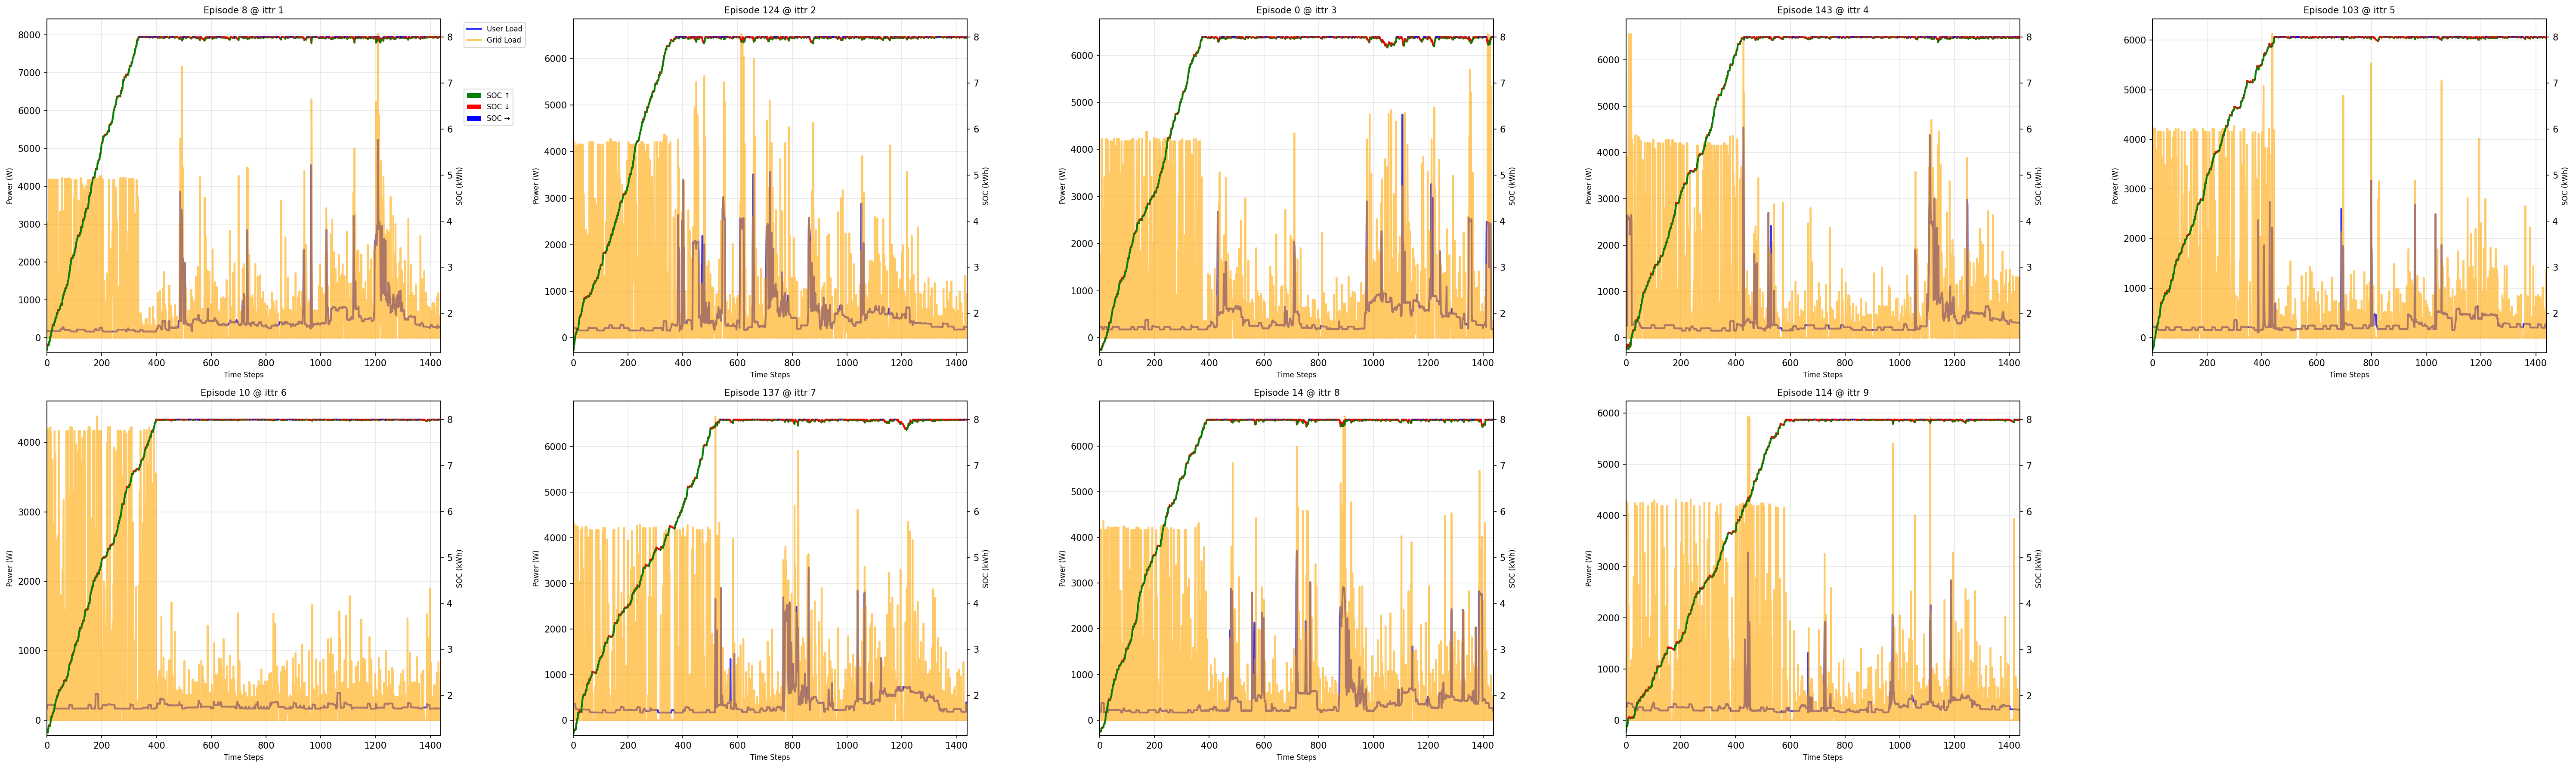

[2025-08-01 02:33:15:077] Episodes grid plot saved to: experiments/20250731_015148_action_continuous_reward_lambda_0.5/logs_train/graphs/multi_episode/episodes_grid_first9.png


In [9]:
# Example usage: Plot first 9 episodes in a grid
if episode_info_dfs is not None and len(episode_info_dfs) > 0:
    print_log(f"Plotting grid of first {min(9, len(episode_info_dfs))} episodes...")
    
    # Create save path
    save_path = expt_phrase_folder / "graphs" / "multi_episode" / "episodes_grid_first9.png"
    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Plot first 9 episodes
    fig = plot_episodes_grid(
        episode_info_dfs, 
        episode_indices=None,  # This will use first 9 episodes
        save_path=None,
        show=True,
        include_curriculum_info=True
    )
    print_log(f"Episodes grid plot saved to: {save_path}")
    
else:
    print_log("No episode data available - creating sample episodes grid plot...")
    
    # Create sample episode data for demonstration
    sample_episodes = []
    for i in range(6):  # Create 6 sample episodes
        time_steps = 144  # 24 hours * 6 (10-minute intervals)
        episode_df = pd.DataFrame({
            'datetime': pd.date_range(f'2025-01-{i+1:02d} 00:00:00', periods=time_steps, freq='10T'),
            'user_load (W)': 2000 + 1000 * np.sin(np.linspace(0, 4*np.pi, time_steps)) + 200 * np.random.random(time_steps),
            'grid_load (W)': 1800 + 800 * np.sin(np.linspace(0.5 + i*0.1, 4.5*np.pi + i*0.1, time_steps)) + 150 * np.random.random(time_steps),
            'battery_soc (kWh)': 50 + 20 * np.sin(np.linspace(0, 2*np.pi, time_steps)) + 2 * np.random.random(time_steps),
            'episode_index': [i] * time_steps,
            'episode': [i+1] * time_steps,
            'episode_data_idx': [i+10] * time_steps
        })
        sample_episodes.append(episode_df)
    
    # Create sample metadata
    global episode_metadata_df
    episode_metadata_df = pd.DataFrame({
        'episode_training_idx': [i+1 for i in range(6)],
        'episode_length_days': [1, 1, 2, 1, 3, 1],
        'curriculum_phase': ['Phase 1', 'Phase 1', 'Phase 2', 'Phase 1', 'Phase 3', 'Phase 2']
    })
    
    fig = plot_episodes_grid(
        sample_episodes, 
        episode_indices=None,
        show=True,
        include_curriculum_info=True
    )
    print_log("Sample episodes grid plot created")

[2025-08-01 02:33:58:378] Plotting specific episodes by indices...


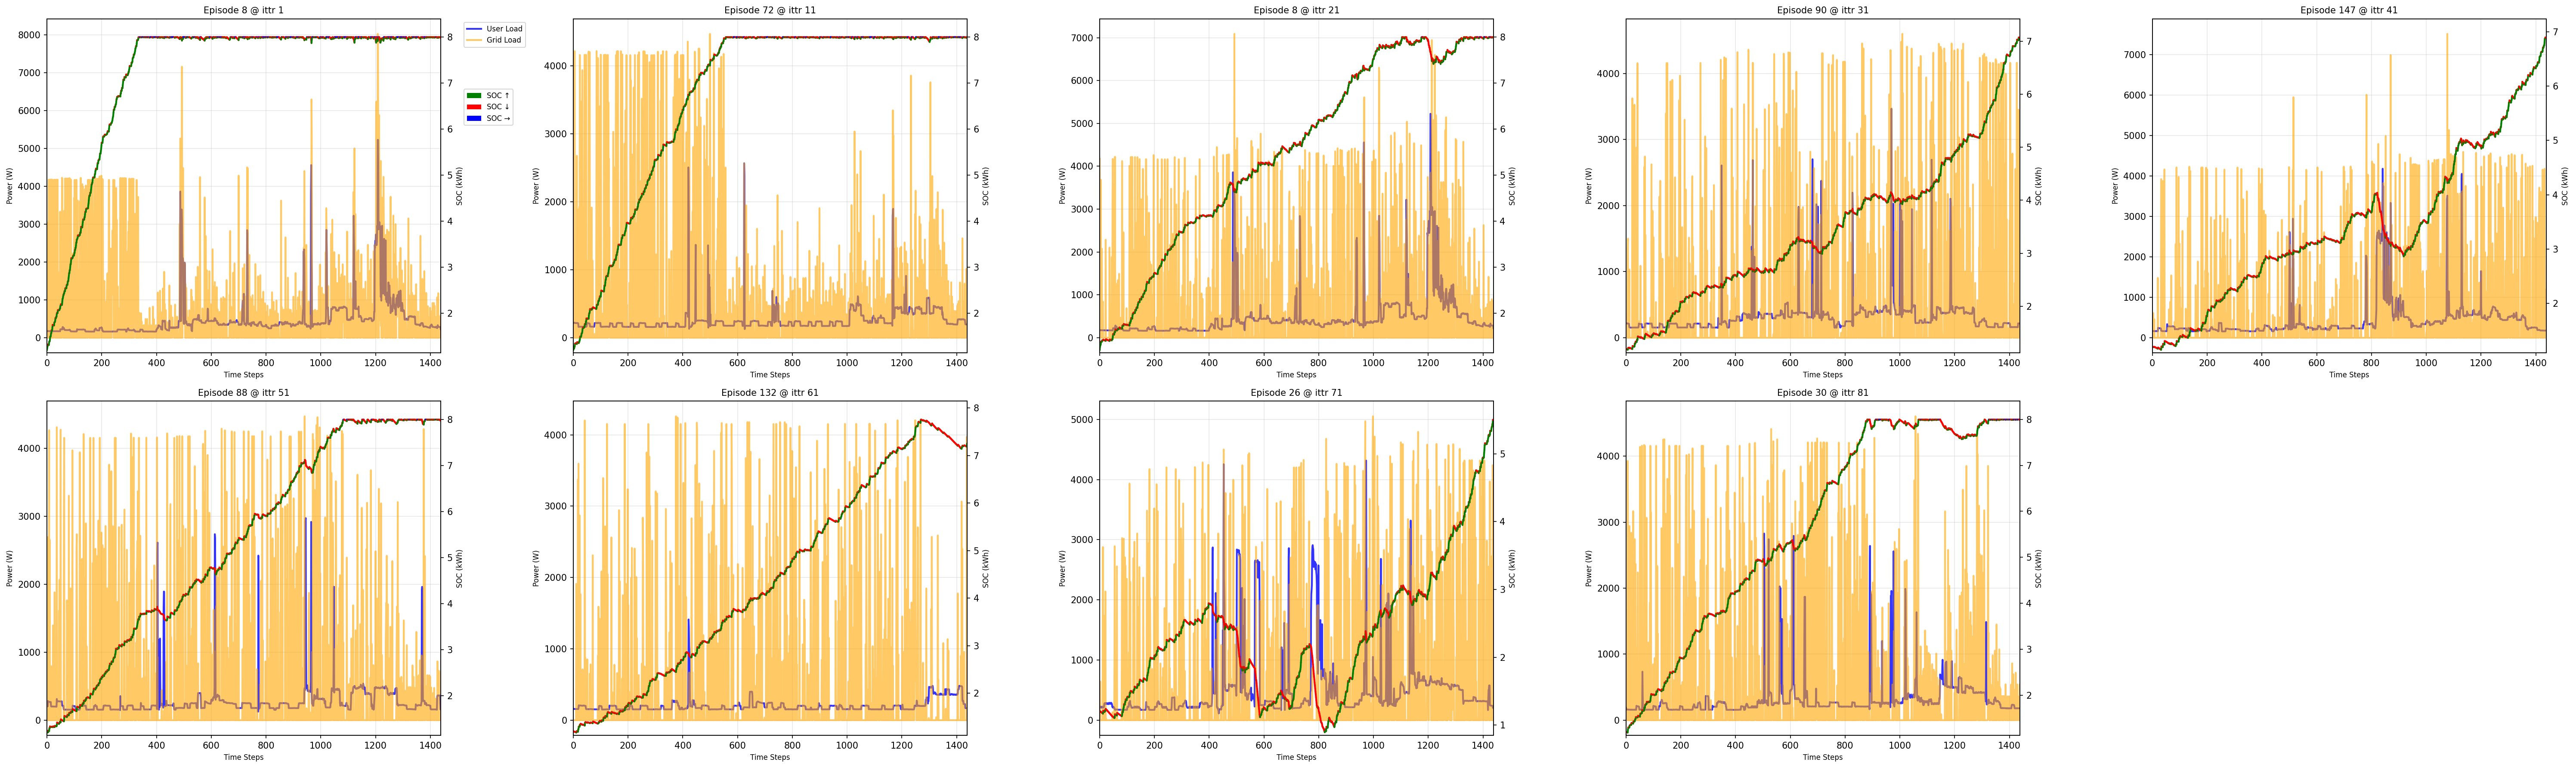

[2025-08-01 02:33:59:615] Selected episodes grid plot saved to: experiments/20250731_015148_action_continuous_reward_lambda_0.5/logs_train/graphs/multi_episode/episodes_grid_every10th.png
[2025-08-01 02:33:59:615] Plotted episodes at indices: [0, 10, 20, 30, 40, 50, 60, 70, 80]


In [10]:
# Example usage: Plot specific episodes by indices
if episode_info_dfs is not None and len(episode_info_dfs) >= 10:
    print_log("Plotting specific episodes by indices...")
    
    # Select every 10th episode for comparison
    selected_indices = [i for i in range(0, len(episode_info_dfs), 10)][:9]  # Max 9 episodes
    
    # Create save path
    save_path = expt_phrase_folder / "graphs" / "multi_episode" / "episodes_grid_every10th.png"
    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Plot selected episodes
    fig = plot_episodes_grid(
        episode_info_dfs, 
        episode_indices=selected_indices,
        save_path=None,
        show=True,
        include_curriculum_info=True
    )
    print_log(f"Selected episodes grid plot saved to: {save_path}")
    print_log(f"Plotted episodes at indices: {selected_indices}")
    
else:
    print_log("Insufficient episode data for specific indices selection - skipping")

In [ ]:
# Example usage: Plot episodes by curriculum phase (if available)
if episode_metadata_df is not None and 'curriculum_phase' in episode_metadata_df.columns:
    curriculum_phases = episode_metadata_df['curriculum_phase'].dropna().unique()
    
    if len(curriculum_phases) > 0:
        print_log(f"Found curriculum phases: {curriculum_phases}")
        
        for phase in curriculum_phases:
            if phase is not None and str(phase) != 'nan':
                # Get episodes from this phase
                phase_episodes = episode_metadata_df[episode_metadata_df['curriculum_phase'] == phase]
                
                if len(phase_episodes) > 0:
                    # Get corresponding episode indices (limit to first 9)
                    phase_indices = phase_episodes.index.tolist()[:9]
                    
                    if len(phase_indices) > 0 and episode_info_dfs is not None:
                        print_log(f"Plotting {len(phase_indices)} episodes from {phase}...")
                        
                        # Create save path
                        save_path = expt_phrase_folder / "graphs" / "multi_episode" / f"episodes_grid_{phase.replace(' ', '_').lower()}.png"
                        if not save_path.parent.exists():
                            save_path.parent.mkdir(parents=True, exist_ok=True)
                        
                        # Plot episodes from this phase
                        fig = plot_episodes_grid(
                            episode_info_dfs, 
                            episode_indices=phase_indices,
                            save_path=save_path,
                            show=False,  # Don't show all to avoid clutter
                            include_curriculum_info=True
                        )
                        print_log(f"Episodes grid for {phase} saved to: {save_path}")
                        
                        # Close figure to save memory
                        if fig:
                            plt.close(fig)
    else:
        print_log("No valid curriculum phases found")
else:
    print_log("No curriculum phase information available")

In [ ]:
# Example usage: Plot episodes by episode length (if available)
if episode_metadata_df is not None and 'episode_length_days' in episode_metadata_df.columns:
    episode_lengths = episode_metadata_df['episode_length_days'].dropna().unique()
    episode_lengths = sorted([length for length in episode_lengths if pd.notna(length)])
    
    if len(episode_lengths) > 1:  # Only plot if there are different lengths
        print_log(f"Found episode lengths: {episode_lengths} days")
        
        for length in episode_lengths:
            # Get episodes of this length
            length_episodes = episode_metadata_df[episode_metadata_df['episode_length_days'] == length]
            
            if len(length_episodes) > 0:
                # Get corresponding episode indices (limit to first 9)
                length_indices = length_episodes.index.tolist()[:9]
                
                if len(length_indices) > 0 and episode_info_dfs is not None:
                    print_log(f"Plotting {len(length_indices)} episodes of {length} day(s)...")
                    
                    # Create save path
                    save_path = expt_phrase_folder / "graphs" / "multi_episode" / f"episodes_grid_{length}day.png"
                    if not save_path.parent.exists():
                        save_path.parent.mkdir(parents=True, exist_ok=True)
                    
                    # Plot episodes of this length
                    fig = plot_episodes_grid(
                        episode_info_dfs, 
                        episode_indices=length_indices,
                        save_path=save_path,
                        show=False,  # Don't show all to avoid clutter
                        include_curriculum_info=True
                    )
                    print_log(f"Episodes grid for {length}-day episodes saved to: {save_path}")
                    
                    # Close figure to save memory
                    if fig:
                        plt.close(fig)
    else:
        print_log("All episodes have the same length - no length-based grouping needed")
else:
    print_log("No episode length information available")

## Summary and Documentation

This notebook provides grid plotting functionality for multi-episode analysis:

### Key Functions:
1. **`plot_episodes_grid()`** - Main function for creating grid layouts of multiple episodes

### Features:
- **Automatic grid layout optimization** based on number of episodes
- **Updated aesthetics** with blue user load and orange grid load (alpha=0.8)
- **Color-coded battery SOC** visualization using LineCollection
- **Curriculum learning information** in titles when available
- **Flexible episode selection** by indices, phases, or lengths
- **Proper legend placement** to avoid overlapping

### Data Requirements:
- **episode_info_dfs**: List of episode DataFrames from `episode_info` folder
- **episode_metadata_df**: DataFrame with curriculum learning metadata
- **Required columns**: 'user_load (W)', 'grid_load (W)', 'battery_soc (kWh)', 'episode', 'episode_index'

### Usage Patterns:
- **Default behavior**: Plots first 9 episodes if no indices specified
- **Custom selection**: Use `episode_indices` parameter for specific episodes
- **Curriculum analysis**: Automatic grouping by phase or episode length
- **Memory management**: Use `show=False` and `plt.close()` for batch processing